In [5]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
print("Libraries imported.")

TensorFlow Version: 2.19.0
Libraries imported.


In [6]:
# Cell 2: Load and Combine Datasets
print("Loading datasets...")

# Load the environmental time-series data
try:
    env_df = pd.read_csv('../data/simulated/environmental_data.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    print("ERROR: environmental_data.csv not found. Please run the '1_data_simulation.ipynb' notebook first.")
    # Stop execution if file is not found
    raise

# Load the soil data which contains our target variable (yield)
try:
    soil_df = pd.read_csv('../data/simulated/soil_microbe_data.csv')
except FileNotFoundError:
    print("ERROR: soil_microbe_data.csv not found. Please run the '1_data_simulation.ipynb' notebook first.")
    raise

# We need to associate the time-series data with a single yield output.
# For this simulation, we'll associate all environmental data for a plot with its final yield.
data_df = pd.merge(env_df, soil_df[['plot_id', 'yield_kg_ha']], on='plot_id')

print("Datasets loaded and merged successfully.")
print("Shape of the combined data:", data_df.shape)
print(data_df.head())

Loading datasets...
Datasets loaded and merged successfully.
Shape of the combined data: (131400, 7)
            timestamp  plot_id  temperature  humidity  soil_moisture  soil_ph  \
0 2024-01-01 00:00:00        0        30.67     74.29          58.80     5.75   
1 2024-01-01 01:00:00        0        30.92     80.56          64.54     5.90   
2 2024-01-01 02:00:00        0        30.22     77.35          61.61     5.88   
3 2024-01-01 03:00:00        0        29.81     85.52          69.10     5.72   
4 2024-01-01 04:00:00        0        31.43     81.97          65.84     5.79   

   yield_kg_ha  
0       1877.3  
1       1877.3  
2       1877.3  
3       1877.3  
4       1877.3  


In [7]:
# Cell 3: Data Preprocessing
print("\nPreprocessing data...")

# Select features for the model and the target
features = ['temperature', 'humidity', 'soil_moisture', 'soil_ph']
target = 'yield_kg_ha'

# Normalize the features to be between 0 and 1 for better model performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_df[features] = scaler.fit_transform(data_df[features])

print("Features normalized.")
print(data_df[features].describe())


Preprocessing data...
Features normalized.
         temperature       humidity  soil_moisture        soil_ph
count  131400.000000  131400.000000  131400.000000  131400.000000
mean        0.494300       0.591438       0.569515       0.487609
std         0.216240       0.227936       0.193736       0.253553
min         0.000000       0.000000       0.000000       0.000000
25%         0.291320       0.386130       0.406709       0.241667
50%         0.494649       0.591301       0.569175       0.450000
75%         0.696790       0.797292       0.735811       0.750000
max         1.000000       1.000000       1.000000       1.000000


In [8]:
# Cell 4: Create Time-Series Sequences
print("\nCreating time-series sequences...")

# We will use a sequence of past environmental data to predict the yield.
# Let's define a sequence length, e.g., one week (24 * 7 = 168 hours).
SEQUENCE_LENGTH = 168
X, y = [], []

# Group data by plot_id to create sequences for each plot
for plot_id, group in data_df.groupby('plot_id'):
    plot_features = group[features].values
    plot_target = group[target].iloc[0] # Yield is constant for a given plot

    # Create overlapping sequences
    for i in range(len(plot_features) - SEQUENCE_LENGTH):
        X.append(plot_features[i:(i + SEQUENCE_LENGTH)])
        y.append(plot_target)

X = np.array(X)
y = np.array(y)

print(f"Created {len(X)} sequences.")
print("Shape of X (sequences):", X.shape) # (num_sequences, timesteps, num_features)
print("Shape of y (targets):", y.shape)


Creating time-series sequences...
Created 128880 sequences.
Shape of X (sequences): (128880, 168, 4)
Shape of y (targets): (128880,)


In [10]:
# Cell 5: Split Data for Training and Testing
print("\nSplitting data into training and testing sets...")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Splitting data into training and testing sets...
Training data shape: (103104, 168, 4)
Testing data shape: (25776, 168, 4)


In [11]:
# Cell 6: Build the 1D-CNN + LSTM Hybrid Model
print("\nBuilding the hybrid model...")

# Define model parameters
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

model = Sequential([
    # 1. Convolutional Layer to extract features from time steps
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # 2. LSTM Layer to understand the sequence of the extracted features
    LSTM(100, activation='relu'),
    Dropout(0.3),

    # 3. Dense Layer to make the final prediction
    Dense(50, activation='relu'),
    Dense(1) # Output layer: predicts a single value (yield)
])

# Compile the model
# We use Mean Squared Error as the loss function for this regression problem
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # MAE: Mean Absolute Error

model.summary()


Building the hybrid model...


C:\Final_Year_Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 166, 64)             │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 164, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 82, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 82, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,285 (329.24 KB)

 Trainable params: 84,285 (329.24 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Cell 7: Train the Model
print("\nTraining the model... (This may take some time)")

# Train the model on the training data
# We use a validation split to monitor performance on unseen data during training
history = model.fit(
    X_train,
    y_train,
    epochs=10, # Start with a few epochs, can be increased later
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("Model training complete.")


Training the model... (This may take some time)
Epoch 1/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 145s 55ms/step - loss: 266169614336.0000 - mae: 6577.3916 - val_loss: 1788747.1250 - val_mae: 1203.0548
Epoch 2/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 157s 61ms/step - loss: 1782788.6250 - mae: 1199.7321 - val_loss: 1788627.3750 - val_mae: 1203.0051
Epoch 3/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 155s 60ms/step - loss: 1782542.7500 - mae: 1199.6296 - val_loss: 1788186.5000 - val_mae: 1202.8220
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - loss: 1781661.6250 - mae: 1199.2606 - val_loss: 1786651.5000 - val_mae: 1202.1832
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 147s 57ms/step - loss: 1778968.0000 - mae: 1198.1387 - val_loss: 1782618.7500 - val_mae: 1200.5050
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 169s 65ms/step - loss: 1773889.5000 - mae: 1196.0167 - val_loss: 1776808.5000 - val_mae: 1198.0839
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 166s 64ms/step - loss: 1767885.2500 - mae: 1193.5066 - val

In [13]:
# Cell 8: Evaluate the Model
print("\nEvaluating the model on the test set...")

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Set Mean Absolute Error (MAE): {mae:.2f} kg/ha")
print(f"This means the model's yield predictions are, on average, off by {mae:.2f} kg/ha.")


Evaluating the model on the test set...
Test Set Mean Absolute Error (MAE): 1188.60 kg/ha
This means the model's yield predictions are, on average, off by 1188.60 kg/ha.



Plotting training history...


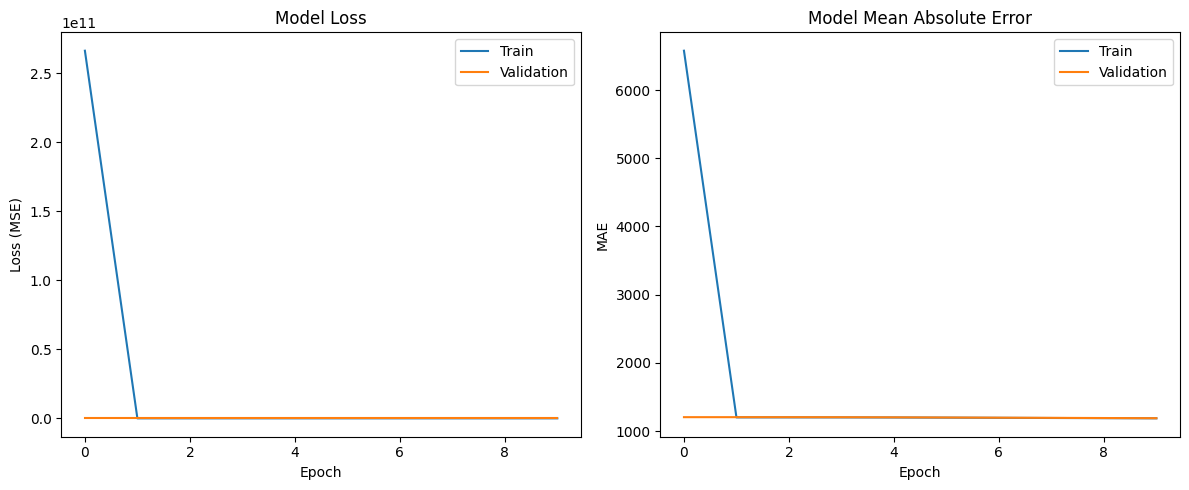

In [14]:
# Cell 9: Plot Training History
print("\nPlotting training history...")

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
# Cell 10: Save the Trained Model
print("\nSaving the trained model...")

# Define the path to save the model
model_dir = '../backend/models/'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'environmental_yield_model.h5')

# Save the model in the HDF5 format
model.save(model_path)

print(f"Model saved successfully to: {model_path}")


Saving the trained model...
Model saved successfully to: ../backend/models/environmental_yield_model.h5
